In [1]:
%pip install bing_image_downloader
%pip install --upgrade tensorflow 

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 80.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 72.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: t

In [2]:
from bing_image_downloader import downloader
import os

# Define the characters and the number of images you want for each
characters = ["Sakura", "Jiraiya", "Sasuke"]
num_images = 50
dataset_dir = "dataset"

# Create the dataset directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Download the images
for character in characters:
    downloader.download(character, limit=num_images, output_dir=dataset_dir, adult_filter_off=True, force_replace=False)


[%] Downloading Images to /mnt/batch/tasks/shared/LS_root/mounts/clusters/workstation/code/Users/askar.nurbekov01/dataset/Sakura


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from http://images2.fanpop.com/images/photos/8400000/Sakura-sakura-haruno-8426495-640-481.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://4.bp.blogspot.com/_djqLyk3QXck/TB1jEppSQ2I/AAAAAAAAAH0/TvAjHHC4i2Y/s1600/Haruno_Sakura_by_tsukishoujo.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://comicvine.gamespot.com/a/uploads/scale_super/11124/111247188/5038047-sakura_haruno_by_s_i_m_c_a-d8pfdxw.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://images6.fanpop.com/image/photos/36000000/Sakura-33333-haruno-sakura-36048437-1024-768.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://4.bp.blogspot.com/-Xy02lBZrUek/TbDsduY9JfI/AAAAAAAAACY/6tja-FerHbw/s1600/sakura_haruno_opis%255B1%255D.jpg
[%] File Downloaded !

[%] Downloading Im

In [3]:
from PIL import Image
import os

def resize_and_rename_images(image_dir, new_width=224, new_height=224):
    filenames = sorted(os.listdir(image_dir))  # sort the filenames
    for idx, filename in enumerate(filenames):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            try:
                img = Image.open(os.path.join(image_dir, filename))
                img = img.resize((new_width, new_height), Image.ANTIALIAS)
                # Convert RGBA images to RGB
                if img.mode == 'RGBA':
                    img = img.convert('RGB')
                # Rename the file
                new_filename = f"{os.path.basename(image_dir)}_{idx}.jpg"
                img.save(os.path.join(image_dir, new_filename))
                # Remove the old file if the new file name is not the same as the old one
                if new_filename != filename:
                    os.remove(os.path.join(image_dir, filename))
            except IOError:
                print(f"Could not process file {filename}. Skipping...")

# Define the characters
characters = ["Sakura", "Jiraiya", "Sasuke"]
dataset_dir = "dataset"

# Resize and rename the images
for character in characters:
    resize_and_rename_images(os.path.join(dataset_dir, character))

In [4]:
import os
from PIL import Image

def delete_bad_and_mismatched_images(directory):
    for subdir, dirs, files in os.walk(directory):
        parent_folder_name = os.path.basename(subdir)
        
        for file in files:
            file_path = os.path.join(subdir, file)
            
            # Check for bad images
            try:
                img = Image.open(file_path)
                img.verify()  # verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                print('Bad file:', file_path)
                os.remove(file_path)  # delete the bad file
                continue  # move to the next file since this one is already deleted
            
            # Check if filename contains folder's name
            if parent_folder_name not in file:
                print('Mismatched file:', file_path)
                os.remove(file_path)  # delete the mismatched file

delete_bad_and_mismatched_images('dataset/')

Mismatched file: dataset/Jiraiya/Image_2.jpeg
Mismatched file: dataset/Jiraiya/Image_39.JPEG
Mismatched file: dataset/Sakura/Image_40.JPG


In [5]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

tf.random.set_seed(8)

image_size = 224
batch_size = 8

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)
predictions = Dense(3, activation='softmax')(x)  # Adjusted for 3 classes
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

data_dir = 'dataset/'
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=45,
                             width_shift_range=0.25,
                             height_shift_range=0.25,
                             shear_range=0.25,
                             zoom_range=0.25,
                             horizontal_flip=True,
                             validation_split=0.3)

train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(image_size, image_size),
                                              batch_size=batch_size,
                                              class_mode='categorical',  # Adjusted for 3 classes
                                              subset='training')

validation_generator = datagen.flow_from_directory(data_dir,
                                                   target_size=(image_size, image_size),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',  # Adjusted for 3 classes
                                                   subset='validation')

early_stopping = EarlyStopping(monitor='val_loss', patience=7)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=100,
                    callbacks=[early_stopping, checkpoint, reduce_lr])

# Fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(train_generator,
                              steps_per_epoch=train_generator.samples // batch_size,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples // batch_size,
                              epochs=50,
                              callbacks=[early_stopping, checkpoint, reduce_lr])


2023-08-09 05:05:59.433507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 05:06:01.427046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-09 05:06:07.261874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94765736/94765736 [==============================] - 0s 0us/step
Found 104 images belonging to 3 classes.
Found 43 images belonging to 3 classes.
Epoch 1/100
13/13 [==============================] - 12s 689ms/step - loss: 9.2803 - accuracy: 0.3654 - val_loss: 8.7122 - val_accuracy: 0.3250 - lr: 1.0000e-04
Epoch 2/100
13/13 [==============================] - 8s 617ms/step - loss: 8.8120 - accuracy: 0.3173 - val_loss: 8.1864 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 3/100
13/13 [==============================] - 10s 759ms/step - loss: 8.3023 - accuracy: 0.2885 - val_loss: 7.6876 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 4/100
13/13 [==============================] - 8s 615ms/step - loss: 7.7222 - accuracy: 0.3558 - val_loss: 7.2280 - val_accuracy: 0.3250 - lr: 1.0000e-04
Epoch 5/100
13/13 [==============================] - 9s 673ms/step - loss: 7.2905 - accu

In [6]:
print('Total number of training samples:', train_generator.samples)
print('Total number of validation samples:', validation_generator.samples)
print('Class labels for training set:', train_generator.classes)
print('Class labels for validation set:', validation_generator.classes)

Total number of training samples: 104
Total number of validation samples: 43
Class labels for training set: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Class labels for validation set: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]


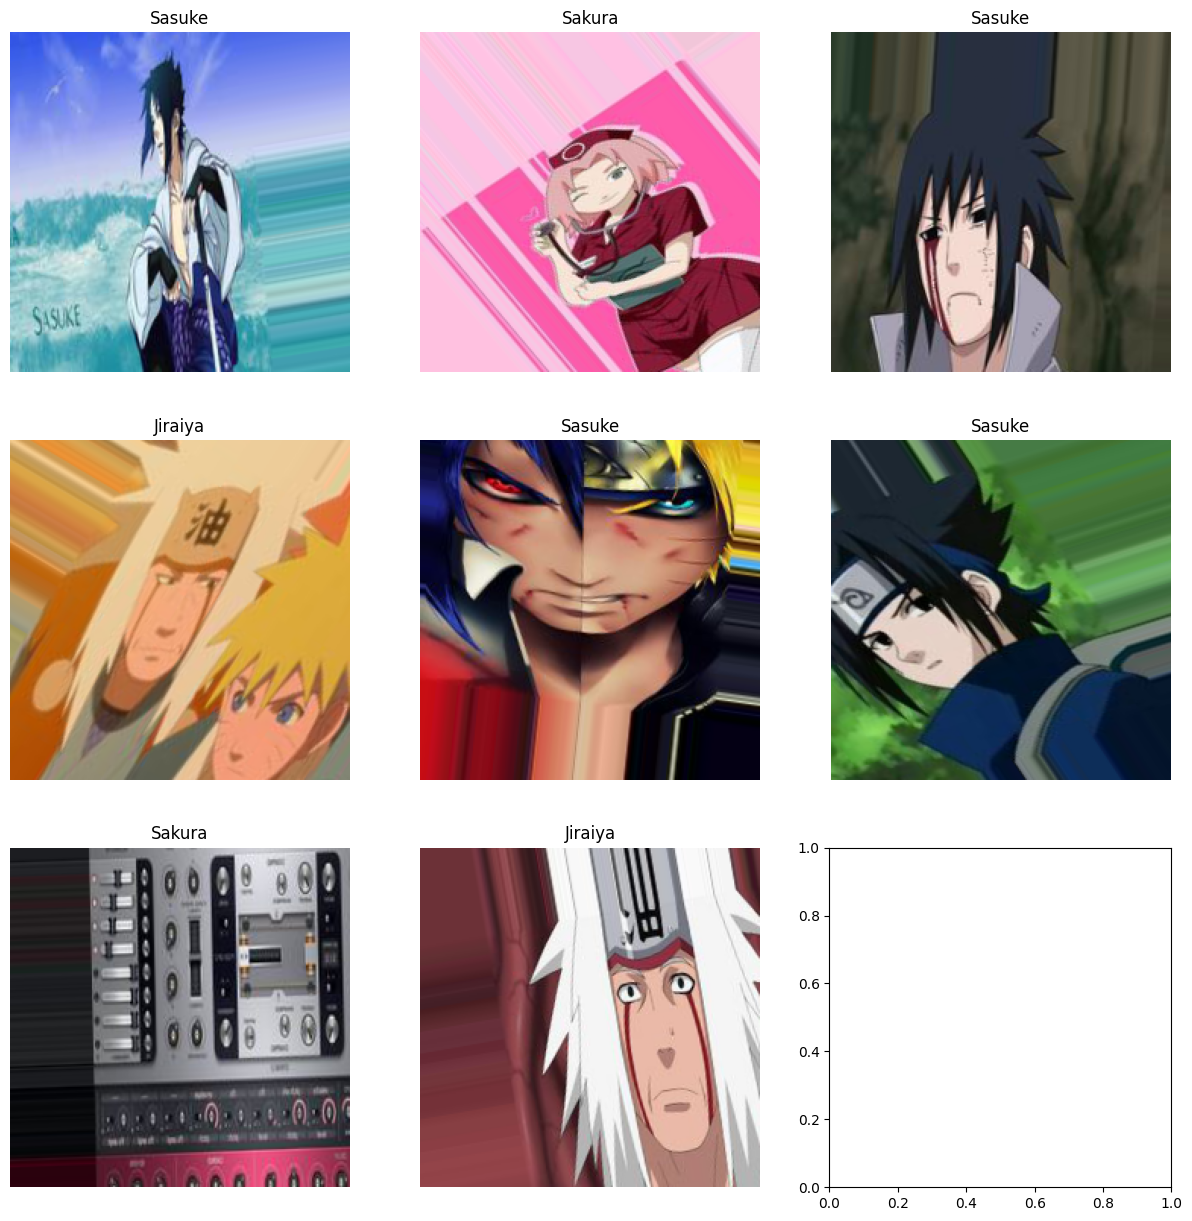

In [7]:

characters = list(train_generator.class_indices.keys())

import matplotlib.pyplot as plt

# Get a batch of data
x, y = next(train_generator)
# Create a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15,15))

# Plot images
for i, ax in enumerate(axes.flat):
    if i < len(x):  # Add this condition to ensure we don't go beyond the batch size
        ax.imshow(x[i])
        ax.set_title(characters[y[i].argmax()])
        ax.axis('off')

plt.show()

1/1 [==============================] - 0s 116ms/step


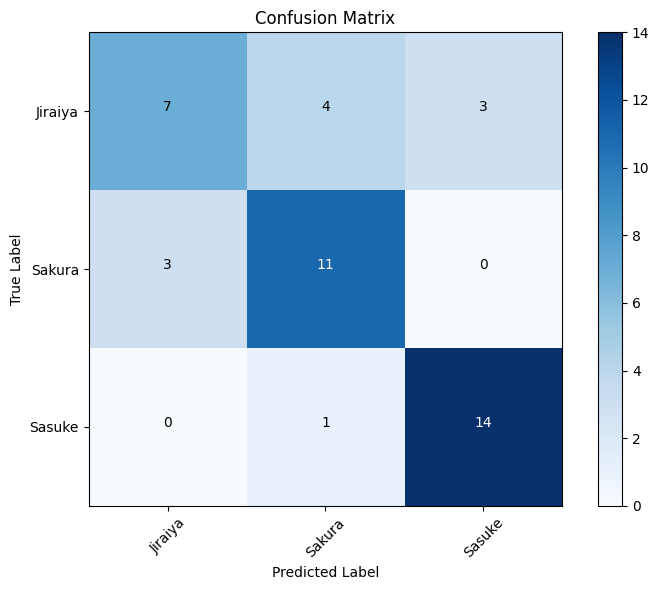

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

characters = list(train_generator.class_indices.keys())

# Generate predictions for the entire validation dataset
true_labels = []
predictions = []

# Iterate over each batch of data
for idx in range(len(validation_generator)):
    x_test, y_test = validation_generator[idx]
    class_probabilities = model.predict(x_test)
    predictions.extend(np.argmax(class_probabilities, axis=1))
    true_labels.extend(np.argmax(y_test, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(characters))
plt.xticks(tick_marks, characters, rotation=45)
plt.yticks(tick_marks, characters)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Displaying the values in the matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [9]:
!pip freeze > requirements.txt

In [10]:
!cat requirements.txt

absl-py==1.4.0
adal==1.2.7
adlfs==2023.4.0
aiohttp==3.8.4
aiohttp-cors==0.7.0
aiosignal==1.3.1
ansiwrap==0.8.4
antlr4-python3-runtime==4.9.3
anyio==3.6.2
applicationinsights==0.11.10
arch==4.14
argcomplete==2.1.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
arviz @ file:///tmp/build/80754af9/arviz_1614019183254/work
astroid==2.15.5
asttokens==2.2.1
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
auto-tqdm==1.0.2
autokeras==1.0.16
autopep8==2.0.2
azure-appconfiguration==1.1.1
azure-batch==13.0.0
azure-cli==2.49.0
azure-cli-core==2.49.0
azure-cli-telemetry==1.0.8
azure-common==1.1.28
azure-core==1.26.4
azure-cosmos==3.2.0
azure-data-tables==12.4.0
azure-datalake-store==0.0.53
azure-graphrbac==0.60.0
azure-identity==1.13.0
azure-keyvault==1.1.0
azure-keyvault-administration==4.3.0
azure-keyvault-certificates==4.7.0
azure-keyvault-keys==4.8.0
azure-keyvault-secrets==4.7.0
azure-loganalytics==0.1.1
azure-mgmt-advisor==9.0.0
azure-mgmt-apimanagement==3.0.0
azure-mgmt-ap

In [11]:
# Save model
model.save_weights("model_weights_only.h5")


In [12]:
# Recreate model
base_model = ResNet50(weights=None, include_top=False)  # Set weights to None

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)
predictions = Dense(3, activation='softmax')(x)  # Adjusted for 3 classes
model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
# load weights
model.load_weights("model_weights_only.h5")


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an image file that contains the image to predict, resizing it to 224x224 pixels (size used during training)
img_path = 'jiraya.jpeg'
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array and scale the pixel values to [0, 1]
img_array = image.img_to_array(img) / 255.

# Expand the dimensions of the image array to represent a batch of size 1
img_batch = np.expand_dims(img_array, axis=0)

# Get predictions
predictions = model.predict(img_batch)

# Here, 'predictions' will be a 2D array with shape (1, 3), where 3 is the number of classes.
# You can use argmax to get the class index with the highest prediction value.
predicted_class = np.argmax(predictions[0])

print(f"Predicted class index: {predicted_class}")
print(f"I believe it's: {characters[predicted_class]}")


1/1 [==============================] - 0s 63ms/step
Predicted class index: 0
I believe it's: Jiraiya


In [18]:
characters

['Jiraiya', 'Sakura', 'Sasuke']